Uses a local copy of the digital-land datasette to generate a csv file with the info needed to retire the duplicated/stale brownfield endpoints.

Download the digital land SQLite3 file from https://datasette.planning.data.gov.uk/digital-land. You can then set the path to it per the next section. Note how the paths of the files show how to do it from WSL2 to your windows host :-) 

In [7]:
dbfile =r'/mnt/c/Users/MarkSmith/Downloads/digital-land_2023_11_16.sqlite3'
csvfile = r'/mnt/c/Users/MarkSmith/Downloads/duplicates.csv'

In [8]:
import sqlite3
import pandas as pd

# Create the connection
cnx = sqlite3.connect(dbfile)

cursor = cnx.cursor()

Create a view in your SQLite file that lists organisations and datasets where the dataset has more than a single source. I could have done this as an inner join but divide and conquer is how I prefer to work.

In [18]:
cursor.execute("drop view duplicates")

duplicates_view_sql = """
create view duplicates as 
select ro.*, org.name || '_' || ds.name as dupkey,  ds.name as dataset,  count( res.resource) as count 
from resource res
inner join resource_organisation ro on ro.resource = res.resource
inner join organisation org on org.organisation = ro.organisation
inner join resource_dataset rd on rd.resource = res.resource
inner join dataset ds on ds.dataset = rd.dataset
where res.end_date = ''
group by 1
having count > 1
"""

cursor.execute(duplicates_view_sql)

df = pd.read_sql_query("SELECT * FROM duplicates order by count desc", cnx)

df.head(15)

,resource,organisation,dupkey,dataset,count
0,9933fb8af06079613a66d7f88426cc1f2ae344ee5154f7...,local-authority-eng:COR,Corby Borough Council_Brownfield land,Brownfield land,5
1,2d3b41725137ce7d5a7c8bb7dbf8d2c983d0d248abb86e...,local-authority-eng:BMH,Bournemouth Borough Council_Brownfield land,Brownfield land,3
2,0926985544238c3b43555433cadeb840b5aa422503870e...,local-authority-eng:WOI,Woking Borough Council_Brownfield land,Brownfield land,2
3,0c035f369a58fefe56046a87edf4f9429ae7c95aefc6a8...,local-authority-eng:NET,Newcastle City Council_Tree preservation order,Tree preservation order,2
4,20ab1d84c669217e70328f90d2379c75c59a3889945bfb...,local-authority-eng:SWK,London Borough of Southwark_Tree preservation ...,Tree preservation order,2
5,2c8acd4d9e2920fb257b14ebcfb42344dea71e76572966...,local-authority-eng:SWK,London Borough of Southwark_Tree preservation ...,Tree preservation order,2
6,45d7caaa863d4a63768ba98311592a722db787de9b2c6d...,local-authority-eng:MDW,Medway Council_Tree preservation order,Tree preservation order,2
7,49a918dc51d8d4063061e5b0d257943aa194370ae1f07a...,local-authority-eng:BAB,Babergh District Council_Brownfield land,Brownfield land,2
8,4d022c2ce0332e5bf87b5ae1ee9c1551b851802bcfce88...,local-authority-eng:CAT,Canterbury City Council_Tree preservation order,Tree preservation order,2
9,60b8ac462544709005df52aa085f15baad4cbba799e64d...,local-authority-eng:FOR,Forest Heath District Council_Brownfield land,Brownfield land,2


dataset
Brownfield land            24
Conservation area           2
Tree                        4
Tree preservation order    14
World heritage site         2
Name: count, dtype: int64


<Axes: ylabel='count'>

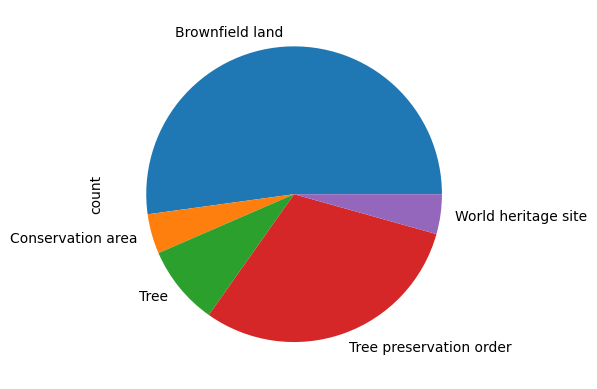

In [10]:
bydataset = df.groupby('dataset')['count'].sum()
print(bydataset)
bydataset.plot.pie()

Now we can build out the endpoints that are candidates for retiring. Note how we use an aggregate of org name and dataset to identify each row. This assumes for each org, a dataset should be unique.

In [11]:
sql = """
select org.name || '_' || ds.name as thiskey, org.name as organization, ds.name as dataset, 
res.start_date as res_start_date, res.resource, ep.endpoint, ep.endpoint_url, ep.start_date as ep_start_date, ep.end_date

from resource res
inner join resource_organisation ro on ro.resource = res.resource
inner join organisation org on org.organisation = ro.organisation
inner join resource_dataset rd on rd.resource = res.resource
inner join dataset ds on ds.dataset = rd.dataset
inner join resource_endpoint re on re.resource = res.resource
inner join endpoint ep on ep.endpoint = re.endpoint

where res.end_date = ''
and thiskey in (select dupkey from duplicates)
order by 2,3,4, ep.start_date 
"""

df = pd.read_sql_query(sql, cnx)

df.to_csv(csvfile)

df.head()

,thiskey,organization,dataset,res_start_date,resource,endpoint,endpoint_url,ep_start_date,end_date
0,Adur District Council_Brownfield land,Adur District Council,Brownfield land,2021-09-09,bd9cd114c5124c93ecd3e6d2f1d8c3492e273d98b5741c...,ea98ea4d156ee47ff09af98d96d09951395b58e66d8b5f...,"https://www.adur-worthing.gov.uk/media/Media,1...",2023-07-06,
1,Babergh District Council_Brownfield land,Babergh District Council,Brownfield land,2018-05-22,49a918dc51d8d4063061e5b0d257943aa194370ae1f07a...,3198d071873720b401c9a37ce0f9ae2c450736af0dd316...,https://www.midsuffolk.gov.uk/assets/Planning-...,,
2,Babergh District Council_Brownfield land,Babergh District Council,Brownfield land,2018-05-22,49a918dc51d8d4063061e5b0d257943aa194370ae1f07a...,cf91b1e94fe298ecf6383060c79b3dd7d030cdfd00bda9...,http://www.babergh.gov.uk/assets/Planning-Poli...,2017-12-21,
3,Babergh District Council_Brownfield land,Babergh District Council,Brownfield land,2018-05-22,49a918dc51d8d4063061e5b0d257943aa194370ae1f07a...,87e1075c7812461e82831a6424d5358d40df2932130162...,https://www.babergh.gov.uk/assets/Planning-Pol...,2023-07-06,
4,Bournemouth Borough Council_Brownfield land,Bournemouth Borough Council,Brownfield land,2021-09-09,2d3b41725137ce7d5a7c8bb7dbf8d2c983d0d248abb86e...,17a4a162ff34961dc2c43bca63663872bfb6ed4523b006...,https://www.bcpcouncil.gov.uk/Planning-and-bui...,2023-07-07,


In [12]:
sql = """
select * from endpoint ep
where ep.start_date = '' and ep.end_date = ''
"""

df = pd.read_sql_query(sql, cnx)

df.head()

,end_date,endpoint,endpoint_url,entry_date,parameters,plugin,start_date
0,,a623eb0a63ee1bbdb778f6e83ea2e10271596aafebacfc...,https://opendata.arcgis.com/datasets/a14064ca5...,2021-05-26T00:00:00Z,,,
1,,f22b13c88a6c367b06e4c80aa61cb1620d7ca03193daeb...,https://raw.githubusercontent.com/digital-land...,2021-12-03T17:17:23Z,,,
2,,34167c688ca765477c47e63592ff9149bb46710a0850f6...,https://raw.githubusercontent.com/digital-land...,2022-09-10T16:16:46Z,,,
3,,351fdbd179616dcf25ce0c4498cbd7fd5a917c5bbedcbc...,https://mapping.canterbury.gov.uk/arcgis/rest/...,2021-11-11T14:14:25Z,,,
4,,d29690420f36280214af4fb7121d131c73d775fb9c6434...,https://mapping.canterbury.gov.uk/arcgis/rest/...,2022-03-28T14:27:45Z,,,
